<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/ChannelFlows/HystogramsPowerProduction/EnergyProduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl

In [59]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py &> /dev/null

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']

Import time series data - "Data.xlsx" file 

In [60]:
import sys, pathlib
if 'google.colab' in sys.modules and not pathlib.Path("Data.xlsx").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/ChannelFlows/HystogramsPowerProduction/Data.xlsx &> /dev/null

## Energy produced

Energy produced during time $T$ for a single turbine 

$$E = \int_0^T P_\mathrm{T} \mathrm{d} t$$

where $P_\mathrm{T}$ is the turbine power and

* $\displaystyle P_\mathrm{T} = \tfrac{1}{2} \rho U^3 A_\mathrm{T} \, C_P$: instantaneous power at turbine shaft
* $C_P$: is the instantaneous power coefficient 
* $U$: instantaneous stream velocity
* $\rho$: water density 
* $A_\mathrm{T}$: turbine swept area

## Capacity factor

If the unit operated at the rated power $P_\text{rated}$ during time $T$ the energy produced is 
$$E_\text{rated} = P_\text{rated} T$$

The capacity factor is defined as annual energy yield over the energy yield at 100% rated power
$$\frac{E}{E_\text{rated}} = \frac{1}{T} \int_0^{T} \frac{P_u(t)}{P_\text{rated}} dt $$

In **general** the instantaneous power is less than the rated power 
$$P(t) < P_\text{rated}$$
and the capacity factor is less than 1


The **annual energy yield** = number of hours/year $\times$ installed power $\times$ capacity factor

e.g. 
$$E = 8760\text{h}\times 10\text{MW} \times 0.35\approx 30\text{GWh/y}$$  

## Computing the annual energy yield

If we know
* $P_\mathrm{T}$ - the Turbine Power Curve as function of velocity 
* $f$ - the frequency distribution of Current Speed classes 


then the energy produce is computed from
$$
E=\int_{U_\text{cut-in}}^{U_\text{cut-out}} P_\mathrm{T} \, f \, \mathrm{d} T \cong \sum P_\mathrm{T} \, f \, \Delta T
$$
where
* $U_\text{cut-in}$: Turbine cut-in speed
* $U_\text{cut-out}$: Turbine cut-out speed

## Maximum energy production vs real

Theoretical conditions for maximum energy production

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/ChannelFlows/HystogramsPowerProduction/figs/PowerCurve_cin_cout.svg?raw=1" width="300px" style="display:inline">

**'Ideal turbine'**
- $U_\text{cut-in}=0$
- $U_\text{cut-out}=\infty$
- always $C_{P,\text{max}}$ 

**Real Turbine**
- $U_\text{cut-in}>0$
- $U_\text{cut-out}$ finite
- Close to $C_{P,\text{max}}$ until $U_\text{rated}$
- $P=P_\text{rated}$  for  $\mathrm{U}>U_\text{rated}$
- $P=0$  for  $U>U_\text{cut-out}$
- Typical values: 
  - $C_{P,\text{max}} \approx 0.35-0.50$

## The annual energy yield considering the turbine curve 

If the Turbine Power Curve is known as function of velocity: $P_{U}(U)$
If the Current Speed is known as function of time:
$$
E=\int_{0}^\text{1 year} P_{u}(U(t)) d t \approx \sum P_{u}(U(t)) \Delta t
$$
where
$$
\begin{array}{ll}
P_{u}(U)=0 & \text { if } U(t)<U_{\text{cut-in}} \\
P_{u}(U)= C_{P} \, \frac{1}{2} \rho U(t)^{3} A & \text { if } U_{\text{cut-in}}<U(t)<U_{\text {rated }} \\
P_{u}(U)=P_{\text {rated }} & \text { if } U_{\text {rated }}<U(t)<U_{\text{cut-out }} \\
P_{u}(U)=0 & \text { if } U_{\text {cut-out }}<U(t)
\end{array}
$$
$\Delta t$ May be taken at $1 \mathrm{~h}$

## Annual energy yield based on histograms

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/ChannelFlows/HystogramsPowerProduction/figs/AnnualEnergy.svg?raw=1" width="600px" style="display:inline">


## Create an histogram

We start by reading an excel file with a time series of velocities at a given location

In [61]:
df = pd.read_excel( 'Data.xlsx', 'Sheet1' )
list(df.keys())

['hrs', 'U']

Assign excel columns to vectors

In [62]:
hrs = np.array( df['hrs'])
U = np.array( df['U'])

abs_U = np.abs( U )
abs_U3 = np.array( abs_U**3 )

Plot an interval of the time series 

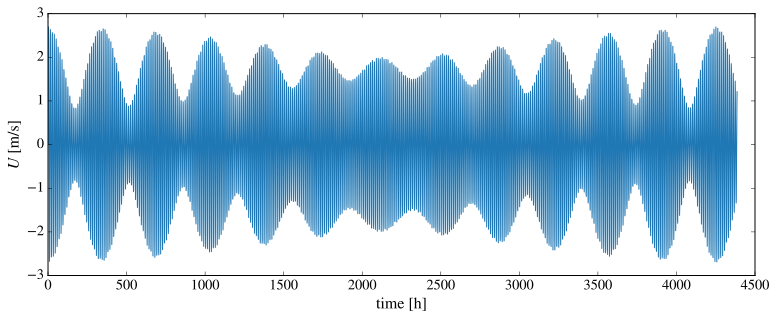

In [63]:
mpl.figure( figsize=(12, 4.5) )
mpl.plot( hrs, U, '-', lw=1 )
mpl.xlabel( r'time [h]' )
mpl.ylabel( r'$U$ [m/s]' )
mpl.savefig( 'TidalStream.pdf', bbox_inches='tight', pad_inches=0.02);

Plot the time series of absolute value of the velocity (note that there is no zero crossing) 

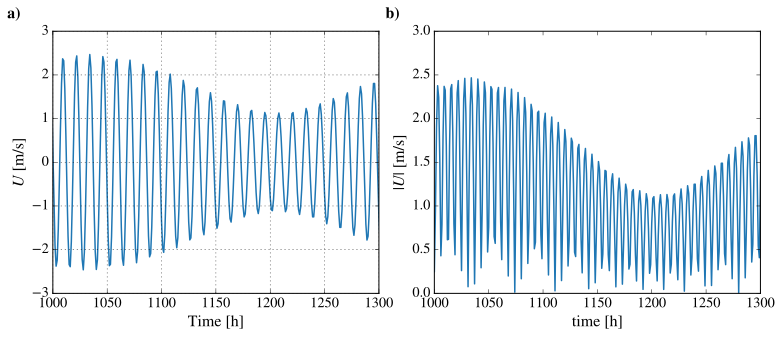

In [64]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.17 )


ax1.plot( hrs, U, '-' )
ax1.grid()
ax1.set_xlabel( r'Time [h]' )
ax1.set_ylabel( r'$U$ [m/s]' )
ax1.set_xlim( 1000,1300 );
ax1.text(-0.14, 1.05, 'a)', transform=ax1.transAxes, size=16, weight='semibold')

ax2.plot( hrs, abs_U )
ax2.set_xlabel( r'time [h]' )
ax2.set_ylabel( r'$|U|$ [m/s]' );
ax2.set_xlim( 1000,1300 )
ax2.text(-0.15, 1.05, 'b)', transform=ax2.transAxes, size=16, weight='semibold')

mpl.savefig( 'TidalStream_Zoom.pdf', bbox_inches='tight', pad_inches=0.02);

## Define bins

In [65]:
# sampling frequency
fs = 1.0 / ( hrs[1] - hrs[0] )

In [66]:
U_bin_size = 0.1
U_max = np.max( abs_U )
U_max_bins = int( U_max / U_bin_size ) + 1
U_max, U_max_bins

(2.695408127824624, 27)

Compute the number of hours in each bin

In [67]:
U_bin_hours = np.zeros( U_max_bins )

for u in abs_U:
  n = int( u / U_bin_size )
  U_bin_hours[n] += 1

U_bin_hours /= fs

Define the labels of the x-axis for plotting

In [68]:
U_bin_classes = np.linspace( 0.0, ( U_max_bins - 1 ) * U_bin_size, U_max_bins )
U_bin_classes += U_bin_size * 0.5
U_bin_labels = [ ( "%.2f" % n) for n in U_bin_classes ]
U_bin_classes

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65])

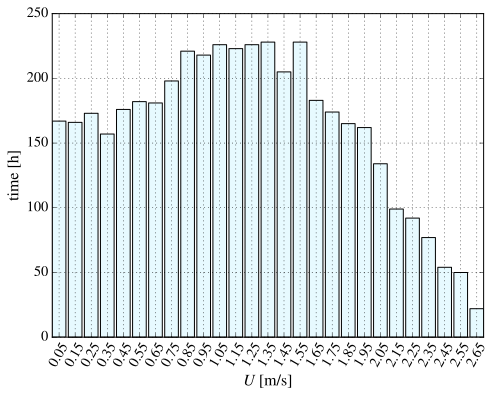

In [69]:
fig = mpl.figure()
ax = fig.add_axes( [ 0, 0, 1, 1 ] )

ax.bar( U_bin_labels, U_bin_hours, width = 0.85, color='#80e5ff30' )

mpl.xlabel( r'$U$ [m/s]' )
mpl.ylabel( r'time [h]' )
mpl.ylim( 0, 250 );
mpl.xticks( U_bin_labels, rotation = 60 );
mpl.grid()
mpl.savefig( 'TidalStream_Bins.pdf', bbox_inches='tight', pad_inches=0.02);

Simulation data for a turbine rotor radius of 4.0m and a rated power of 120kW

In [70]:
At = np.pi*4.0**2
Prated = 120E3

CP = 0.48 # at optimal TSR (best efficiency point)
rho_w = 1000

Cut-in values

In [92]:
U_cut_in = 0.5
P_cut_in = 0.5*rho_w*U_cut_in**3*At * CP

U_cut_out = U_bin_classes[-1]

U_rated = (2.0*Prated/(rho_w*At*CP))**(1.0/3.0)

Compute the turbine curve 

In [93]:
U_cur = U_bin_classes

Pwr = 0.5 * rho_w * U_cur**3 * At * CP

Pwr_lim = np.copy( Pwr )
Pwr_lim[ Pwr <= P_cut_in ] = 0.0
Pwr_lim[ Pwr >= Prated   ] = Prated

Pwr_kW = Pwr / 1000.0
Pwr_lim_kW = Pwr_lim / 1000.0

Plot the ideal and the 'real' curve and the impose $C_P$ curve

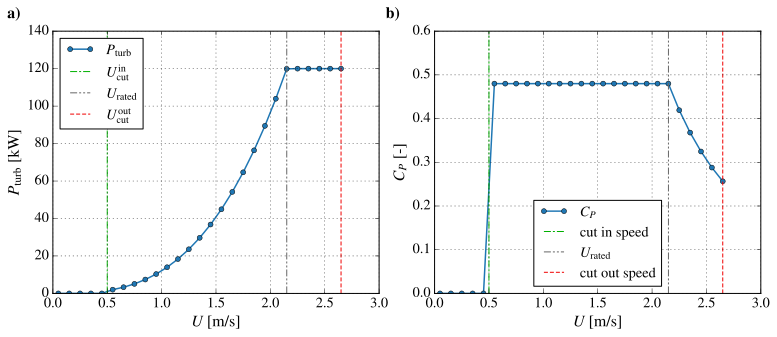

In [95]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.17 )


# ax1.plot( U_cur, Pwr_kW, '-', label='unconstrained' )
ax1.plot( U_cur, Pwr_lim_kW, 'o-', label='$P_\mathrm{turb}$' )
ax1.set_xlabel('$U$ [m/s]')
ax1.set_ylabel('$P_\mathrm{turb}$ [kW]' )
ax1.set_ylim( -5,200 )
ax1.grid()
ax1.set_ylim( 0, 140 )
ax1.text(-0.14, 1.05, 'a)', transform=ax1.transAxes, size=16, weight='semibold')
ax1.axvline( U_cut_in, dashes=(7,2,2,2), color='#00B000', lw=1, label='$U_\mathrm{cut}^\mathrm{in}$' )
ax1.axvline( U_rated, dashes=(7,2,2,2,2,2), color='#666666', lw=1, label='$U_\mathrm{rated}$' )
ax1.axvline( U_cut_out, dashes=(4,2), color='#F00000', lw=1, label='$U_\mathrm{cut}^\mathrm{out}$' )
ax1.legend( loc='upper left' )

Pwr[0] = 1E-6 # avoid division by zero
CP_lim = ( Pwr_lim / Pwr ) * CP 

ax2.plot( U_cur,  CP_lim, 'o-', label='$C_P$' )
ax2.set_xlabel( r'$U$ [m/s]' )
ax2.set_ylabel( r'$C_P$ [-]' )
ax2.set_ylim( 0, 0.60 )
ax2.grid()
ax2.text(-0.15, 1.05, 'b)', transform=ax2.transAxes, size=16, weight='semibold')
ax2.axvline( U_cut_in, dashes=(7,2,2,2), color='#00B000', lw=1, label='cut in speed' )
ax2.axvline( U_rated, dashes=(7,2,2,2,2,2), color='#666666', lw=1, label='$U_\mathrm{rated}$' )
ax2.axvline( U_cut_out, dashes=(4,2), color='#F00000', lw=1, label='cut out speed' )
ax2.legend( loc='lower center' )

mpl.savefig( 'TidalStream_PT_CP.pdf', bbox_inches='tight', pad_inches=0.02);

create pretty table just for displaying

In [75]:
Pwr_lim_kW = np.round( Pwr_lim_kW, 1 )
Energy = np.round( Pwr_lim_kW * U_bin_hours, 1 )
Time = np.sum( U_bin_hours )

dfdic = { "$U$ [m/s]":U_cur, "time [h]":U_bin_hours, "$P_\mathrm{turb}$ [kW]":Pwr_lim_kW, "Energy [kWh]":Energy }
df = pd.DataFrame( dfdic )
df.to_excel( "Results.xlsx", index=False )
df.to_latex( "Results.tex", index=False , escape=False )

df

,$U$ [m/s],time [h],$P_\turb [kW]$,Energy [kWh]
0,0.05,167.0,0.0,0.0
1,0.15,166.0,0.0,0.0
2,0.25,173.0,0.0,0.0
3,0.35,157.0,0.0,0.0
4,0.45,176.0,0.0,0.0
5,0.55,182.0,2.0,364.0
6,0.65,181.0,3.3,597.3
7,0.75,198.0,5.1,1009.8
8,0.85,221.0,7.4,1635.4
9,0.95,218.0,10.3,2245.4


Annual Power production is the dot product of two columns above

In [76]:
Energy = np.dot( U_bin_hours, Pwr_lim_kW )
print( "Energy production = %.1fkWh" % Energy )

Average_Power = Energy / np.sum( U_bin_hours )
print( "Average Power = %.1fkW" % Average_Power )

print( "Total time = %.1f" % Time )

Energy production = 152457.3kWh
Average Power = 34.8kW
Total time = 4387.0
